In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003681929, 'queue_time': 0.049232471, 'total_time': 0.053681929}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_92412bc7e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-05c5c8f4-1629-40bd-bdf8-81aa19057bb2-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [5]:
from youtube_transcript_api import YouTubeTranscriptApi
from IPython.display import Image, display

from typing import TypedDict, Optional
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

class State(TypedDict):
    video_url: str
    transcript: str
    blog: str
    feedback:str
    final_blog: str

def extract_transcript(state: State) -> State:

    """Extracts transcript from a YouTube video URL."""

    if "video_url" not in state:
        raise KeyError("Missing 'video_url' in state.")
    video_id = state["video_url"].split("v=")[-1]  # Extract video ID
    transcript = YouTubeTranscriptApi.get_transcript(video_id)
    text_transcript = " ".join([t["text"] for t in transcript])
    state["transcript"] = text_transcript
    print("Transcript Extracted")
    return state

def chunk_text(text: str, max_tokens: int = 500):

    """Splits text into chunks of max_tokens words."""

    words = text.split()
    chunks = []
    for i in range(0, len(words), max_tokens):
        chunks.append(" ".join(words[i:i + max_tokens]))
    return chunks

def generate_blog_section(chunk: str) -> str:

    """Generates a blog section for a given transcript chunk."""

    # prompt_text = f"""
    #     You are a professional blog writer skilled in writing engaging, informative, and SEO-friendly articles.
    #     Convert the following YouTube transcript chunk into a well-structured blog section:
        
    #     {chunk}
        
    #     Ensure it is engaging and easy to read.
    # """
    prompt_text = f"""
    Generate a structured blog based on the following YouTube transcript chunk:
    {chunk}

    Structure:
    1. **Title**: A compelling blog title
    2. **Introduction**: A brief introduction
    3. **Headings & Subheadings**
    4. **Conclusion**: A strong closing statement

    Keep the response concise, and do not exceed 3000 tokens.

    """
    return llm.invoke(prompt_text).content  # Invoke LLM for each chunk

def generate_blog(state: State) -> State:

    """Generates a full blog by processing transcript chunks separately."""
    
    transcript_chunks = chunk_text(state["transcript"])  # Split transcript
    blog_sections = [generate_blog_section(chunk) for chunk in transcript_chunks]  # Process chunks
    state["blog"] = "\n\n".join(blog_sections)  # Combine sections
    return state
    


def human_feedback(state: State) -> dict:
    print("\n-------------------------------------------✅ Blog Draft ------------------------------------ \n", state["blog"])
    choice = input("\nDo you want to provide feedback to refine the blog? (yes/no/accepted): ").strip().lower()
    
    if choice == "yes":
        state["feedback"] = input("\nEnter your feedback to refine the blog: ")
        return {"feedback": state["feedback"], "refine_blog": state["blog"]}
    elif choice == "accepted":
        state["feedback"] = "Accepted"
        print("\n------------------------------------ Blog Accepted ----------------------------------------------\n")
        return {"feedback": "Accepted"}  # Ends workflow
    else:
        state["feedback"] = "No feedback provided."
        print("\n------------------------------------ No feedback provided.---------------------------------------------- \n")
        return {"feedback": "No feedback provided."}  # Ends workflow

def refine_blog(state: State, llm) -> dict:
    
    feedback = state.get("feedback", "No human feedback provided.")
    
    prompt = f"Revise the blog considering following feedback provided from user : {feedback}\n\n Blog Content: {state['blog']}"
    print("\n\n\n 🖍🖍 Refining blog as per the following feedback : ",feedback)
    # Call LLM to refine the blog
    final_blog = llm.invoke(prompt).content
    state["final_blog"] = final_blog

    print("\n✅ Blog Finalized Successfully!\n")
    
    return {
        "blog": final_blog,    # Update the blog with the refined version
        "final_blog": final_blog  # Store the final blog version
    }

# Conditional edges for feedback loop
def route_after_feedback(state):
    if state["feedback"] == "Accepted" or state["feedback"] == "No feedback provided.":
        return END  # ✅ Ends workflow if feedback is accepted or no feedback is given
    return "refine_blog"  # ✅ Loops back to refining



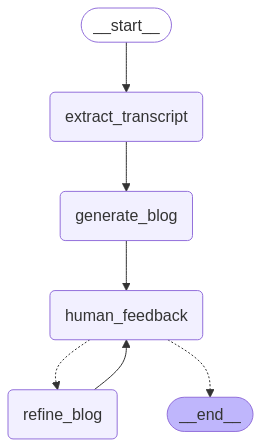

In [6]:
# builder = StateGraph(State)
# builder.add_node("extract_transcript", extract_transcript)
# builder.add_node("generate_blog", generate_blog)

# builder.add_edge(START, "extract_transcript")
# builder.add_edge("extract_transcript", "generate_blog")
# builder.add_edge("generate_blog",END)

# graph = builder.compile()

# display(Image(graph.get_graph().draw_mermaid_png()))

def generate_graph(llm):
    builder = StateGraph(State)
       
    builder.add_node("extract_transcript", extract_transcript)
    builder.add_node("generate_blog", generate_blog)
    builder.add_node("human_feedback", human_feedback)
    builder.add_node("refine_blog", lambda state: refine_blog(state, llm)) 

    builder.add_edge(START, "extract_transcript")
    builder.add_edge("extract_transcript", "generate_blog")
    builder.add_edge("generate_blog", "human_feedback")
    builder.add_edge("refine_blog", "human_feedback")  # ✅ Loop back to get more feedback if needed

    # Conditional edge based on feedback
    # builder.add_conditional_edges("human_feedback", refine_blog, ["generate_blog",END])
    # builder.add_conditional_edges(
    #     "human_feedback",
    #     lambda state: "refine_blog" if state.get("feedback") != "No feedback provided." else "END"
    # )
    builder.add_conditional_edges("human_feedback", route_after_feedback, ["refine_blog", END])
    graph = builder.compile()
    display(Image(graph.get_graph().draw_mermaid_png()))
    return graph

graph=generate_graph(llm)
print(graph)


In [7]:
url="https://www.youtube.com/watch?v=bxuYDT-BWaI&ab_channel=Exponent"
# initial_state: State = { "video_url": url,
#     "transcript": None, 
#     "blog": None } 


initial_state: State = {
        "video_url": url,
        "transcript": "",
        "blog": "",
        "feedback": "",  # No need to store permanently
        "final_blog":""
    }
# Thread
messages= graph.invoke(initial_state)

# Ensure the final blog is printed correctly
if "final_blog" in messages:
    print("\n------------------------------------ ✅ Final Blog Output: ------------------------------------ \n", messages["final_blog"])
else:
    print("\n❌ Error: 'final_blog' key missing in output state.")


Transcript Extracted

-------------------------------------------✅ Blog Draft ------------------------------------ 
 ### Title: Understanding APIs: The Bridge Between Applications

### Introduction
In the modern digital landscape, communication between various software applications is essential for many operations, from web browsing to mobile app functionality. One of the most crucial components facilitating this communication is the API, or Application Programming Interface. But what exactly is an API, and why is it critical for the tech industry? In this blog post, we'll break down the concept of APIs, explore their importance, and provide a clear understanding of how they work through relatable examples.

### What is an API?
An API, or Application Programming Interface, is a set of protocols and tools for building software applications. It specifies how software components should interact. In simpler terms, an API is like a bridge that connects two applications, allowing them to exc

In [ ]:
graph.update_state(thread,{"feedback":[HumanMessage(content="No, actually multiply 15 and 5!")]})